# **Assessment of the ability to repay loans to small and medium-sized businesses**

The objective of this project is find optimal model to decide whether an SBA loan should be approved.
Small Business Administration (SBA) acts much like an insurance provider to reduce the risk for a bank by taking on some of the risk through guaranteeing a portion of the loan. In the case that a loan goes into default, SBA then covers the amount they guaranteed.

In Poland, there is a similar program offered by BGK, implemented to improve access to financing for companies from the SME sector and to provide an offer of widely available guarantees supporting the development of enterprises.

I was a credit analyst in a bank for three years where I provided loans to small and medium-sized businesses.

I liked the fact that I was able to delve into the financial statements of companies from various industries, which were often family companies. In this work, I found out what small and medium-sized enterprises face and what features a good borrower has.

# DATASET USED

The dataset is from the U.S. Small Business Administration (SBA). 

The full set is available here: https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied




# Imports
I am using a typical data science stack: numpy, pandas, sklearn, matplotlib.

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Import Data



In [2]:
data = pd.read_csv('SBAnational.csv')
data_copy = data.copy()


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.shape
data_copy.shape

(899164, 27)

# Explore Data

In [4]:
data.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,84,4,2.0,0,0,1,0,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,60,2,2.0,0,0,1,0,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,180,7,1.0,0,0,1,0,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,60,2,1.0,0,0,1,0,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,240,14,1.0,7,7,1,0,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [5]:
# Displays column names, non-null values and type 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

## Examine the Target Column

The MIS_Status is what we are want to predict: 
defaulted/charged off (CHGOFF) or have been successfully paid in full (PIF). I transoformed MIS_Status to   binary variables: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties.

In [6]:
data['MIS_Status'].unique()

array(['P I F', 'CHGOFF', nan], dtype=object)

In [7]:
data['good_bad'] = data['MIS_Status'].replace({'P I F':'1','CHGOFF':'0'}, regex=True)
data['good_bad'] = data['good_bad'].astype(float)
data['good_bad']

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
899159    1.0
899160    1.0
899161    1.0
899162    0.0
899163    1.0
Name: good_bad, Length: 899164, dtype: float64

In [8]:
data['good_bad'].value_counts()

1.0    739609
0.0    157558
Name: good_bad, dtype: int64

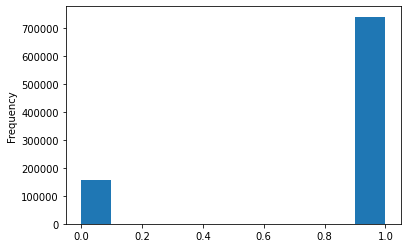

In [9]:
data['good_bad'].plot.hist()

Next I can look at the number  of missing values in each column.

In [10]:
def mv(data):
        length = len(data)
        mv = data.isnull().sum()
        mv_percent = 100 * mv / length
        mv_table = pd.concat([mv, mv_percent], axis=1)
        mv_table = mv_table[mv_table.iloc[:,1] != 0].sort_values(1, ascending=False).round(1)
        mv_table =mv_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        return mv_table

In [11]:
mv(data)

,Missing Values,% of Total Values
ChgOffDate,736465,81.9
RevLineCr,4528,0.5
LowDoc,2582,0.3
DisbursementDate,2368,0.3
MIS_Status,1997,0.2
good_bad,1997,0.2
BankState,1566,0.2
Bank,1559,0.2
NewExist,136,0.0
City,30,0.0


The most missing data is in the ChgOffDate column. It is as much as 81.9%. This is date when a loan is declared to be in default. I decided to remove this column, due to the fact that we have a lot of missing data and the date when the loan was repaid does not contribute anything to our model.

In [12]:
data = data.drop(columns = 'ChgOffDate')

The data set consists of 899.164 rows, so I decided to remove the remaining missing data.

In [13]:
data = data.dropna()

In [14]:
mv(data)

,Missing Values,% of Total Values


# Column Types

In [15]:
data.dtypes.value_counts()

object     16
int64       9
float64     2
dtype: int64

In [16]:
data.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Name                 769838
City                  32298
State                    51
Bank                   5788
BankState                56
ApprovalDate           9786
ApprovalFY               64
RevLineCr                18
LowDoc                    8
DisbursementDate       8435
DisbursementGross    117753
BalanceGross             15
MIS_Status                2
ChgOffPrinGr          82645
GrAppv                21922
SBA_Appv              37935
dtype: int64

In [17]:
data.shape

(886240, 27)

In [18]:
data.head(3)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,good_bad
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,84,4,2.0,0,0,1,0,N,Y,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00",1.0
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,60,2,2.0,0,0,1,0,N,Y,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00",1.0
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,180,7,1.0,0,0,1,0,N,N,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00",1.0


In [19]:
data['NAICS']

0         451120
1         722410
2         621210
3              0
4              0
           ...  
899159    451120
899160    451130
899161    332321
899162         0
899163         0
Name: NAICS, Length: 886240, dtype: int64

The column describing the sector is of the int type. We know from the documentation that this numer description of the first two digits of NAICS. I replaced the numbers with sector names.

In [20]:
data['Sector_name'] = data['NAICS'].astype('str').apply(lambda x: x[:2])

data['Sector_name']= data['Sector_name'].map({
    '11': 'Agriculture/forestry/fishing/hunting',
    '21': 'Mining/quarrying/oil/ gas extraction',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale_trade',
    '44': 'Retail_trade',
    '45': 'Retail_trade',
    '48': 'Trans/Ware',
    '49': 'Trans/Ware',
    '51': 'Information',
    '52': 'Finance/Insurance',
    '53': 'Real estate and rental/leasing',
    '54': 'Professional, scientific, and technical services',
    '55': 'Management of companies and enterprises',
    '56': 'Administrative and support and waste management and remediation services',
    '61': 'Educational services',
    '62': 'Health care and social assistance',
    '71': 'Arts, entertainment, and recreation',
    '72': 'Accommodation and food services',
    '81': 'Other services',
    '92': 'Public administration'
})

In [21]:
sector_other = 'other'
data['Sector_name'] = data['Sector_name'].replace(np.NaN, sector_other)
data['Sector_name']

0                              Retail_trade
1           Accommodation and food services
2         Health care and social assistance
3                                     other
4                                     other
                        ...                
899159                         Retail_trade
899160                         Retail_trade
899161                        Manufacturing
899162                                other
899163                                other
Name: Sector_name, Length: 886240, dtype: object

In [22]:
data['ApprovalFY'].unique()

array([1997, 1980, 2006, 1998, 1999, 2000, 2001, 1972, 2003, 2004, 1978,
       1979, 1981, 2005, 1982, 1983, 1973, 1984, 2007, 1985, 1986, 1987,
       2008, 1988, 2009, 1989, 1991, 1990, 1974, 2010, 2011, 1992, 1993,
       2002, 2012, 2013, 1994, 2014, 1975, 1977, 1976, '2004', '1994',
       '1979', '1976', '1975', '1974', '1977', '1981', '1982', '1983',
       '1984', '1978', '1980', '1968', '1976A', '1969', '1995', '1970',
       '2005', '1996', '1971', 1996, 1971], dtype=object)

One record including an 'A'. I clean these next.

In [23]:
data['ApprovalFY'] = data['ApprovalFY'].replace('1976A', '1976')

*'DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'* columns that represent values in currency $ are values of type object. I changed them to float values. I also changed the format in the case of columns containing date ('ApprovalDate', 'DisbursementDate', 'ApprovalFY'). These columns were also of type object.

In [24]:
d1 = data[['DisbursementGross']].replace('[\$,]', '', regex=True).astype(float)
d2 = data[['BalanceGross']].replace('[\$,]', '', regex=True).astype(float)
d3 = data[['ChgOffPrinGr']].replace('[\$,]', '', regex=True).astype(float)
d4 = data[['GrAppv']].replace('[\$,]', '', regex=True).astype(float)
d5 = data[['SBA_Appv']].replace('[\$,]', '', regex=True).astype(float)
date1 = pd.to_datetime(data['ApprovalDate'], format='%d-%b-%y', errors='ignore')
date2 = pd.to_datetime(data['DisbursementDate'], format='%d-%b-%y', errors='ignore')
year = data['ApprovalFY'].astype(float)

In [25]:
d = pd.concat([d1, d2, d3, d4, d5, date1, date2, year], axis=1)
d

,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,ApprovalDate,DisbursementDate,ApprovalFY
0,60000.0,0.0,0.0,60000.0,48000.0,1997-02-28,1999-02-28,1997.0
1,40000.0,0.0,0.0,40000.0,32000.0,1997-02-28,1997-05-31,1997.0
2,287000.0,0.0,0.0,287000.0,215250.0,1997-02-28,1997-12-31,1997.0
3,35000.0,0.0,0.0,35000.0,28000.0,1997-02-28,1997-06-30,1997.0
4,229000.0,0.0,0.0,229000.0,229000.0,1997-02-28,1997-05-14,1997.0
...,...,...,...,...,...,...,...,...
899159,70000.0,0.0,0.0,70000.0,56000.0,1997-02-27,1997-09-30,1997.0
899160,85000.0,0.0,0.0,85000.0,42500.0,1997-02-27,1997-10-31,1997.0
899161,300000.0,0.0,0.0,300000.0,225000.0,1997-02-27,1997-09-30,1997.0
899162,75000.0,0.0,46383.0,75000.0,60000.0,1997-02-27,1997-03-31,1997.0


In [26]:
data = pd.concat([data,d], axis=1)

In [27]:
data = data.iloc[:,[0,1,2,3,4,5,6,10,11,12,13,14,15,16,17,18,26,27,28,29,30,31,32,33,34,35]]
data

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,good_bad,Sector_name,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,ApprovalDate,DisbursementDate,ApprovalFY
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,84,4,2.0,0,0,1,0,N,Y,1.0,Retail_trade,60000.0,0.0,0.0,60000.0,48000.0,1997-02-28,1999-02-28,1997.0
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,60,2,2.0,0,0,1,0,N,Y,1.0,Accommodation and food services,40000.0,0.0,0.0,40000.0,32000.0,1997-02-28,1997-05-31,1997.0
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,180,7,1.0,0,0,1,0,N,N,1.0,Health care and social assistance,287000.0,0.0,0.0,287000.0,215250.0,1997-02-28,1997-12-31,1997.0
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,60,2,1.0,0,0,1,0,N,Y,1.0,other,35000.0,0.0,0.0,35000.0,28000.0,1997-02-28,1997-06-30,1997.0
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,240,14,1.0,7,7,1,0,N,N,1.0,other,229000.0,0.0,0.0,229000.0,229000.0,1997-02-28,1997-05-14,1997.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,9995573004,FABRIC FARMS,UPPER ARLINGTON,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,60,6,1.0,0,0,1,0,0,N,1.0,Retail_trade,70000.0,0.0,0.0,70000.0,56000.0,1997-02-27,1997-09-30,1997.0
899160,9995603000,FABRIC FARMS,COLUMBUS,OH,43221,JPMORGAN CHASE BANK NATL ASSOC,IL,60,6,1.0,0,0,1,0,Y,N,1.0,Retail_trade,85000.0,0.0,0.0,85000.0,42500.0,1997-02-27,1997-10-31,1997.0
899161,9995613003,"RADCO MANUFACTURING CO.,INC.",SANTA MARIA,CA,93455,"RABOBANK, NATIONAL ASSOCIATION",CA,108,26,1.0,0,0,1,0,N,N,1.0,Manufacturing,300000.0,0.0,0.0,300000.0,225000.0,1997-02-27,1997-09-30,1997.0
899162,9995973006,"MARUTAMA HAWAII, INC.",HONOLULU,HI,96830,BANK OF HAWAII,HI,60,6,1.0,0,0,1,0,N,Y,0.0,other,75000.0,0.0,46383.0,75000.0,60000.0,1997-02-27,1997-03-31,1997.0


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886240 entries, 0 to 899163
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   LoanNr_ChkDgt      886240 non-null  int64         
 1   Name               886240 non-null  object        
 2   City               886240 non-null  object        
 3   State              886240 non-null  object        
 4   Zip                886240 non-null  int64         
 5   Bank               886240 non-null  object        
 6   BankState          886240 non-null  object        
 7   Term               886240 non-null  int64         
 8   NoEmp              886240 non-null  int64         
 9   NewExist           886240 non-null  float64       
 10  CreateJob          886240 non-null  int64         
 11  RetainedJob        886240 non-null  int64         
 12  FranchiseCode      886240 non-null  int64         
 13  UrbanRural         886240 non-null  int64   

In [29]:
data['NewExist'].unique()

array([2., 1., 0.])

In [30]:
data[data['NewExist']==0]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,good_bad,Sector_name,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,ApprovalDate,DisbursementDate,ApprovalFY
142,1001235008,"NEW ENGLAND PAINT & SUPPLY, IN",READING (TOWN OF),MA,1867,DANVERSBANK,MA,84,4,0.0,0,0,1,0,0,N,1.0,other,100000.0,0.0,0.0,100000.0,50000.0,1997-05-21,1999-03-31,1997.0
170,1001385007,Mill City Club,Lawrence,MA,1841,BANK OF AMERICA NATL ASSOC,NC,180,2,0.0,0,0,1,0,0,N,1.0,Accommodation and food services,70000.0,0.0,0.0,70000.0,35000.0,1997-06-16,1997-11-30,1997.0
185,1001485002,"LBC BILLING, LLC",PROVIDENCE,RI,2908,BANK OF AMERICA NATL ASSOC,NC,36,1,0.0,0,0,1,0,0,N,1.0,Information,10000.0,0.0,0.0,10000.0,5000.0,1997-07-02,1999-04-30,1997.0
211,1001685003,Comprehensive Psychiatric Asso,Weston (Town of),MA,2193,BANK OF AMERICA NATL ASSOC,NC,12,10,0.0,0,0,1,0,0,N,1.0,other,100000.0,0.0,0.0,100000.0,50000.0,1997-09-19,1997-11-30,1997.0
223,1001785009,West Reading Used Furniture,West Reading,PA,19611,WELLS FARGO BANK NATL ASSOC,PA,18,3,0.0,0,0,1,0,0,N,1.0,other,20000.0,0.0,0.0,20000.0,10000.0,1997-10-10,1998-04-30,1998.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895872,9923063005,"VAN-JONES HARDWOOD CO., INC",CRYSTAL SPRING,PA,15536,FARMERS & MERCHANTS TR CO,PA,12,7,0.0,0,0,1,0,Y,N,1.0,Wholesale_trade,250000.0,0.0,0.0,250000.0,225000.0,1997-01-27,1997-02-28,1997.0
895976,9925253007,"ACO ENTERPRISES, INC.",SALT LAKE CITY,UT,84050,WELLS FARGO BANK NATL ASSOC,SD,12,2,0.0,0,0,1,0,N,N,1.0,Manufacturing,50000.0,0.0,0.0,50000.0,45000.0,1997-01-28,1997-02-28,1997.0
896382,9933633003,"FIRST CLASS TAN, INC.",HOT SPRINGS,AR,71913,BANK OF AMERICA NATL ASSOC,AR,60,3,0.0,0,0,1,0,N,Y,1.0,other,18700.0,0.0,0.0,23000.0,18400.0,1997-01-30,1997-02-28,1997.0
896633,9939223010,BO SHANNON GRAPHIC PRODUCTION,LEE'S SUMMIT,MO,64064,COUNTRY CLUB BANK,KS,60,1,0.0,0,0,1,0,N,Y,1.0,other,60000.0,0.0,0.0,60000.0,48000.0,1997-02-03,1997-06-30,1997.0


According to the documentation, the column 'NewExist' takes two values of 1 or 2, so I kept in the file only those columns that take these values.

In [31]:
data = data[(data['NewExist'] == 1) | (data['NewExist'] == 2)]

In [32]:
data['NewExist'] = data['NewExist'].replace({1.0: 0, 2.0:1})
data.NewExist.value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.0    636139
1.0    249080
Name: NewExist, dtype: int64

In [33]:
data['FranchiseCode'].unique()

array([    1,     0, 15100, ...,  2899, 18701, 15930])

There is information in the documentation that 'Franchise code, (00000 or 00001) = No franchise.' I created the IsFranchise flag column.

In [34]:
data['FranchiseCode'] = np.where((data.FranchiseCode <= 1 ),0,1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
data['FranchiseCode'].value_counts()

0    834089
1     51130
Name: FranchiseCode, dtype: int64

In [36]:
data['RevLineCr'].value_counts()

N    414512
0    257307
Y    198236
T     15100
1        22
R        14
`        11
2         6
C         2
4         1
7         1
5         1
Q         1
3         1
A         1
.         1
,         1
-         1
Name: RevLineCr, dtype: int64

In [37]:
data['RevLineCr'] = np.where((data['RevLineCr'] != 'N') & (data['RevLineCr'] != 'Y'), np.nan, data.RevLineCr)
data['LowDoc'] = np.where((data['LowDoc'] != 'N') & (data['LowDoc'] != 'Y'), np.nan, data.RevLineCr)
print(data['RevLineCr'].unique())
print(data['LowDoc'].unique())


['N' nan 'Y']
['N' nan 'Y']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
data = data.dropna()


In [39]:
data['RevLineCr'] = np.where((data.RevLineCr == 'Y'),1,data.RevLineCr)
data['RevLineCr'] = np.where((data.RevLineCr == 'N'),0,data.RevLineCr)
data['LowDoc'] = np.where((data.LowDoc == 'Y'),1,data.LowDoc)
data['LowDoc'] = np.where((data.LowDoc == 'N'),0,data.LowDoc)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610187 entries, 0 to 899163
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   LoanNr_ChkDgt      610187 non-null  int64         
 1   Name               610187 non-null  object        
 2   City               610187 non-null  object        
 3   State              610187 non-null  object        
 4   Zip                610187 non-null  int64         
 5   Bank               610187 non-null  object        
 6   BankState          610187 non-null  object        
 7   Term               610187 non-null  int64         
 8   NoEmp              610187 non-null  int64         
 9   NewExist           610187 non-null  float64       
 10  CreateJob          610187 non-null  int64         
 11  RetainedJob        610187 non-null  int64         
 12  FranchiseCode      610187 non-null  int64         
 13  UrbanRural         610187 non-null  int64   

In [41]:
data['LowDoc'].unique()

array([0, 1], dtype=object)

In [42]:
data['LowDoc'] = data['LowDoc'].replace({'N': 0, 'Y':1})


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 610187 entries, 0 to 899163
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   LoanNr_ChkDgt      610187 non-null  int64         
 1   Name               610187 non-null  object        
 2   City               610187 non-null  object        
 3   State              610187 non-null  object        
 4   Zip                610187 non-null  int64         
 5   Bank               610187 non-null  object        
 6   BankState          610187 non-null  object        
 7   Term               610187 non-null  int64         
 8   NoEmp              610187 non-null  int64         
 9   NewExist           610187 non-null  float64       
 10  CreateJob          610187 non-null  int64         
 11  RetainedJob        610187 non-null  int64         
 12  FranchiseCode      610187 non-null  int64         
 13  UrbanRural         610187 non-null  int64   

# Modeling

I need to build a classification model in order to predict whether or not a loan will default. Before building models I removed the columns we found to be insignificant like Name and City.

In [44]:
data = data.drop(['LoanNr_ChkDgt','Name','City','State', 'Bank','Zip','BankState', 'ApprovalDate', 'DisbursementDate', 'GrAppv' ], axis = 1)

In [45]:
data.head()

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,good_bad,Sector_name,DisbursementGross,BalanceGross,ChgOffPrinGr,SBA_Appv,ApprovalFY
0,84,4,1.0,0,0,0,0,0,0,1.0,Retail_trade,60000.0,0.0,0.0,48000.0,1997.0
1,60,2,1.0,0,0,0,0,0,0,1.0,Accommodation and food services,40000.0,0.0,0.0,32000.0,1997.0
2,180,7,0.0,0,0,0,0,0,0,1.0,Health care and social assistance,287000.0,0.0,0.0,215250.0,1997.0
3,60,2,0.0,0,0,0,0,0,0,1.0,other,35000.0,0.0,0.0,28000.0,1997.0
4,240,14,0.0,7,7,0,0,0,0,1.0,other,229000.0,0.0,0.0,229000.0,1997.0


 I used the pandas get_dummies(df) function for one-hot encoding.

In [46]:
data = pd.get_dummies(data)

data.head()

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,LowDoc,good_bad,DisbursementGross,BalanceGross,ChgOffPrinGr,SBA_Appv,ApprovalFY,RevLineCr_0,RevLineCr_1,Sector_name_Accommodation and food services,Sector_name_Administrative and support and waste management and remediation services,Sector_name_Agriculture/forestry/fishing/hunting,"Sector_name_Arts, entertainment, and recreation",Sector_name_Construction,Sector_name_Educational services,Sector_name_Finance/Insurance,Sector_name_Health care and social assistance,Sector_name_Information,Sector_name_Management of companies and enterprises,Sector_name_Manufacturing,Sector_name_Mining/quarrying/oil/ gas extraction,Sector_name_Other services,"Sector_name_Professional, scientific, and technical services",Sector_name_Public administration,Sector_name_Real estate and rental/leasing,Sector_name_Retail_trade,Sector_name_Trans/Ware,Sector_name_Utilities,Sector_name_Wholesale_trade,Sector_name_other
0,84,4,1.0,0,0,0,0,0,1.0,60000.0,0.0,0.0,48000.0,1997.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,60,2,1.0,0,0,0,0,0,1.0,40000.0,0.0,0.0,32000.0,1997.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,180,7,0.0,0,0,0,0,0,1.0,287000.0,0.0,0.0,215250.0,1997.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,60,2,0.0,0,0,0,0,0,1.0,35000.0,0.0,0.0,28000.0,1997.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,240,14,0.0,7,7,0,0,0,1.0,229000.0,0.0,0.0,229000.0,1997.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Extract the target column and split the data into train and test.

In [47]:
y = data['good_bad']
X = data.drop('good_bad', axis=1)

scale = StandardScaler()
X_scaled = scale.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y)
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (457640, 36)
y_train shape: (457640,)
X_test shape: (152547, 36)
y_test shape: (152547,)


In [48]:
lg = LogisticRegression()

lg.fit(X_train, y_train)
y_log_pred = lg.predict(X_test)

print(classification_report(y_test, y_log_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.979     0.922     0.950     27573
         1.0      0.983     0.996     0.989    124974

    accuracy                          0.982    152547
   macro avg      0.981     0.959     0.970    152547
weighted avg      0.982     0.982     0.982    152547



Logistic Regression model has a  accuracy at 98,2% and  F1-score of 95% for defaulted loans.   The precision suggests that the model is correct 97,9% of the time when the loan defaults.

In [49]:
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier()
dtc.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [50]:
print(dtc.score(X_train,y_train))
print(dtc.score(X_test,y_test))

0.999997814876322
0.9882134686358959


In [51]:
dtc_pred = dtc.predict(X_test)

In [52]:
acc = accuracy_score(y_test, dtc_pred)
print(f'Accuracy: {acc}')

Accuracy: 0.9882134686358959


In [53]:
print(classification_report(y_test, dtc_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.972     0.963     0.967     27573
         1.0      0.992     0.994     0.993    124974

    accuracy                          0.988    152547
   macro avg      0.982     0.978     0.980    152547
weighted avg      0.988     0.988     0.988    152547



Decision Tree model has a  accuracy at 98,8% and  F1-score of 96,7% for defaulted loans.   The precision suggests that the model is correct 97,2% of the time when the loan defaults.

In [59]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
forest.fit(X_train,y_train)
forest_pred = forest.predict(X_test)
print(classification_report(y_test, forest_pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.973     0.997     0.985     27573
         1.0      0.999     0.994     0.997    124974

    accuracy                          0.994    152547
   macro avg      0.986     0.995     0.991    152547
weighted avg      0.994     0.994     0.994    152547



Random Forest model has a accuracy at 99,4% and F1-score of 98,5% for defaulted loans. The precision suggests that the model is correct 97,3% of the time when the loan defaults.




In [61]:
cm1 =confusion_matrix(y_test,y_log_pred)
cm2 =confusion_matrix(y_test, dtc_pred)
cm3 =confusion_matrix(y_test,forest_pred)

In [62]:
import plotly.figure_factory as ff

def plot_confusion_matrix(cm):
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_1', 'true_0'])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index), 
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=400, height=400, title='Confusion Matrix', font_size=16)
    fig.show()

plot_confusion_matrix(cm1)
plot_confusion_matrix(cm2)
plot_confusion_matrix(cm3)

The performance of all my models was over 90% accurate, which means that all models can be considered helpful in predicting loan repayment.

It is clear, however, that in our analysis lacked the financial statements of companies that in my opinion are crucial to assess the ability to repay loans.